In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
import os

In [2]:
os.environ['NEURITE_BACKEND'] = 'pytorch'
os.environ['VXM_BACKEND'] = 'pytorch'

In [3]:
import voxelmorph as vxm
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import ToTensor

In [4]:
class ImageRegistrationDataset(Dataset):
    def __init__(self, pairs_file):
        self.image_pairs = []
        with open(pairs_file, 'r') as file:
            for line in file:
                moving, fixed = line.strip().split()
                self.image_pairs.append((moving, fixed))

    def __len__(self):
        return len(self.image_pairs)

    def __getitem__(self, idx):
        moving_path, fixed_path = self.image_pairs[idx]

        # Load images as numpy arrays
        moving_image = np.load(moving_path)
        fixed_image = np.load(fixed_path)
        # Convert numpy arrays to PyTorch tensors and add the batch dimension
        # Also, permute dimensions to match the desired shape: [batch_size, channels, height, width]
        moving_tensor = torch.from_numpy(moving_image).unsqueeze(0).float()
        fixed_tensor = torch.from_numpy(fixed_image).unsqueeze(0).float()

        return [moving_tensor, fixed_tensor], [fixed_tensor]

Inputs Length: 2
Inputs[0] Shape: torch.Size([1, 1, 1024, 1024])
Inputs[1] Shape: torch.Size([1, 1, 1024, 1024])
y_true Length: 1
y_true[0] Shape: torch.Size([1, 1, 1024, 1024])
y_true[0][0][0] max_val: 1.0
y_true[0][0][0] max_val: 0.0


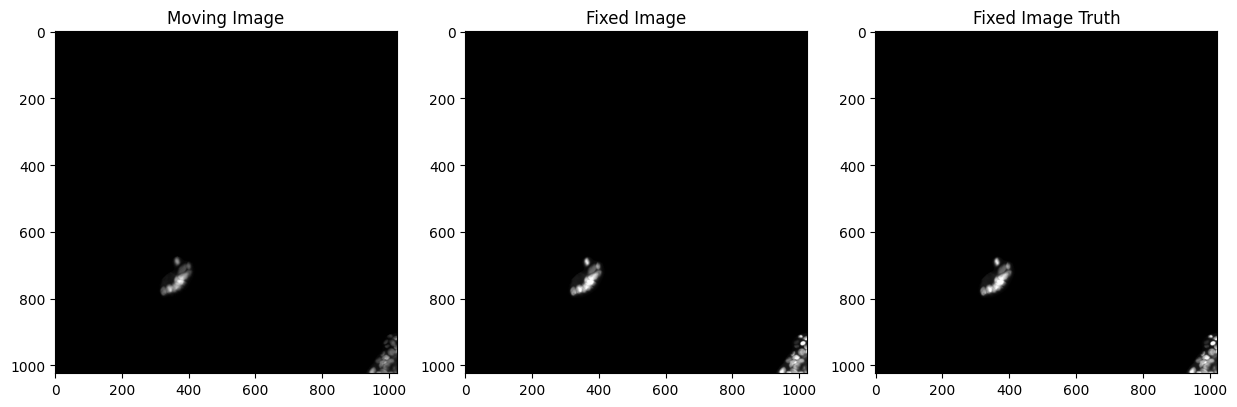

In [5]:
# Initialize dataset
train_dataset = ImageRegistrationDataset('/home-local/rudravg/test_DAPI/1024_Dataset/train_pairs.txt')
val_dataset = ImageRegistrationDataset('/home-local/rudravg/test_DAPI/1024_Dataset/val_pairs.txt')
# Create data loader with batch_size=1 since you are loading one batch at a time
train_data_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
val_data_loader = DataLoader(val_dataset, batch_size=1, shuffle=True)
# Example of iterating over the data loader
for inputs, y_true in val_data_loader:
    print(f'Inputs Length: {len(inputs)}')
    print(f'Inputs[0] Shape: {inputs[0].shape}')
    print(f'Inputs[1] Shape: {inputs[1].shape}')
    print(f'y_true Length: {len(y_true)}')
    print(f'y_true[0] Shape: {y_true[0].shape}')
    print(f'y_true[0][0][0] max_val: {y_true[0][0][0].max()}')
    print(f'y_true[0][0][0] max_val: {y_true[0][0][0].min()}')

    # Plotting
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    plt.imshow(inputs[0][0].numpy().squeeze(), cmap='gray')
    plt.title('Moving Image')
    plt.subplot(1, 3, 2)
    plt.imshow(inputs[1][0].numpy().squeeze(), cmap='gray')
    plt.title('Fixed Image')
    plt.subplot(1, 3, 3)
    plt.imshow(y_true[0][0].numpy().squeeze(), cmap='gray')
    plt.title('Fixed Image Truth')
    plt.show()

    # Your training logic here
    break

In [6]:
len(train_data_loader), len(val_data_loader)

(8376, 1032)

In [13]:
limited_train_dataset = torch.utils.data.Subset(train_dataset, range(8000))
limited_val_dataset = torch.utils.data.Subset(val_dataset, range(1000))

# Create a DataLoader with the limited dataset
train_data_loader = DataLoader(limited_train_dataset, batch_size=5, shuffle=True)
val_data_loader = DataLoader(limited_val_dataset, batch_size=5, shuffle=False)

In [14]:
len(train_data_loader), len(val_data_loader)

(1600, 200)

In [19]:
IN_SHAPE=(1024,1024)
model=vxm.networks.VxmDense(inshape=IN_SHAPE)

In [20]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
model.to(device)
model.train()
optimizer=torch.optim.Adam(model.parameters(), lr=1e-3)

In [21]:
image_loss_func=vxm.losses.NCC().loss 
losses=[image_loss_func]
weights=[1]

In [22]:
losses += [vxm.losses.Grad('l2',loss_mult=2).loss]
weights += [0.01]

In [23]:
epoch_loss_final=[]
epoch_val_loss_final=[]
inference_dir='/home-local/rudravg/test_DAPI/1024_Dataset/epochs_1600/'
best_val_loss = float('inf')
patience = 20
epochs_no_improve = 0
import time
for epoch in range(500):
    ########### Training ###########
    start_time = time.time() 
    model.train()
    epoch_loss=[]
    epoch_total_loss=[]
    val_loss=[]

    for inputs, y_true in train_data_loader:
        inputs = [i.to(device) for i in inputs]
        y_true = [i.to(device) for i in y_true]
        y_pred=model(*inputs)
        loss=0
        loss_list=[]
        for n,loss_function in enumerate(losses):
            curr_loss=loss_function(y_true[0],y_pred[0])*weights[n]
            loss_list.append(curr_loss.item())
            loss+=curr_loss
        epoch_loss.append(loss_list)
        epoch_total_loss.append(loss.item())    
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    epoch_loss_final.append(np.mean(epoch_total_loss))

    ########### Inference ###########
    with torch.inference_mode():
        epoch_dir = os.path.join(inference_dir, f'epoch_{epoch}')
        os.makedirs(epoch_dir, exist_ok=True)
        model.save(os.path.join(epoch_dir, f'epoch_{epoch}.pth'))
        model.eval()
        i=0
        for inputs, y_true in val_data_loader:
            i+=1
            inputs = [i.to(device) for i in inputs]
            y_true = [i.to(device) for i in y_true]
            y_pred=model(*inputs)
            loss=0
            for n,loss_function in enumerate(losses):
                curr_loss=loss_function(y_true[0],y_pred[0])*weights[n]
                loss+=curr_loss
            val_loss.append(loss.item())
            plt.figure(figsize=(15, 5))
            plt.subplot(1, 3, 1)
            plt.imshow(inputs[0][0].cpu().numpy().squeeze(), cmap='gray')
            plt.title('Moving Image')
            plt.subplot(1, 3, 2)
            plt.imshow(inputs[1][0].cpu().numpy().squeeze(), cmap='gray')
            plt.title('Fixed Image')
            plt.subplot(1, 3, 3)
            plt.imshow(y_pred[0][0].detach().cpu().numpy().squeeze(), cmap='gray')
            plt.title('Registered Image')
            plt.savefig(os.path.join(epoch_dir, f'pair_{i}.png'))  # Save the plot as an image
            plt.close()
        epoch_val_loss_final.append(np.mean(val_loss))
    mean_val_loss = np.mean(val_loss)
    if mean_val_loss < best_val_loss:
        best_val_loss = mean_val_loss
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
    if epochs_no_improve == patience:
        print(f'Early stopping on epoch {epoch}')
        break
    end_time = time.time()  # End time
    epoch_time = end_time - start_time  # Time taken for the epoch
    print('------------------------------------------------------')
    print(f'Epoch: {epoch} Loss: {np.mean(epoch_total_loss)}')
    print(f'Epoch {epoch} Val Loss: {np.mean(val_loss)}')
    print(f'Epoch {epoch} Losses: {np.mean(epoch_loss, axis=0)}')
    print(f'Time taken for epoch: {epoch_time} seconds')
    print('------------------------------------------------------')

------------------------------------------------------
Epoch: 0 Loss: -0.22779566853365396
Epoch 0 Val Loss: -0.2443998616267345
Epoch 0 Losses: [-2.27800766e-01  5.09804377e-06]
Time taken for epoch: 710.2000505924225 seconds
------------------------------------------------------
------------------------------------------------------
Epoch: 1 Loss: -0.23545676526569878
Epoch 1 Val Loss: -0.2602770903869532
Epoch 1 Losses: [-2.35462064e-01  5.29815864e-06]
Time taken for epoch: 707.4761030673981 seconds
------------------------------------------------------
------------------------------------------------------
Epoch: 2 Loss: -0.2431803832447622
Epoch 2 Val Loss: -0.22477480113273487
Epoch 2 Losses: [-2.4318595e-01  5.5663424e-06]
Time taken for epoch: 708.464554309845 seconds
------------------------------------------------------
------------------------------------------------------
Epoch: 3 Loss: -0.19642727066122462
Epoch 3 Val Loss: -0.22414737158425851
Epoch 3 Losses: [-1.9643235

KeyboardInterrupt: 

In [76]:
from my_utils import Utils
model,device=Utils.load_model('/home-local/rudravg/test_DAPI/1024_Dataset/epochs_1600/epoch_0/epoch_0.pth')

In [77]:
fixed_image = np.load('/home-local/rudravg/test_DAPI/1024_Dataset/target_images/GCA002ACB_Set01_Cut_2048_1024.npy')
moving_image = np.load('/home-local/rudravg/test_DAPI/1024_Dataset/source_images/Sub_GCA002ACB_Set_Set01_Round_source_3_Cut_2048_1024.npy')
fixed_image = torch.from_numpy(fixed_image).unsqueeze(0).unsqueeze(0).float().to(device)
moving_image = torch.from_numpy(moving_image).unsqueeze(0).unsqueeze(0).float().to(device)
moving_image.shape




torch.Size([1, 1, 1024, 1024])

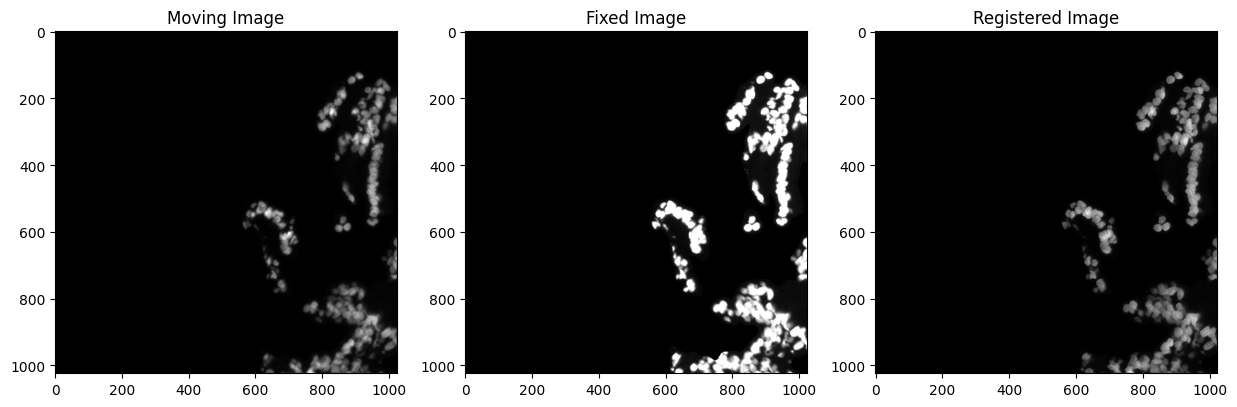

In [78]:
with torch.no_grad():
    y_pred = model(moving_image, fixed_image)
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    plt.imshow(moving_image[0][0].cpu().numpy().squeeze(), cmap='gray')
    plt.title('Moving Image')
    plt.subplot(1, 3, 2)
    plt.imshow(fixed_image[0][0].cpu().numpy().squeeze(), cmap='gray')
    plt.title('Fixed Image')
    plt.subplot(1, 3, 3)
    plt.imshow(y_pred[0][0].cpu().numpy().squeeze(), cmap='gray')
    plt.title('Registered Image')
    plt.show()

In [79]:
y_pred=y_pred[0].detach().cpu().numpy().squeeze().squeeze()

In [80]:
fixed_image = np.load('/home-local/rudravg/test_DAPI/1024_Dataset/target_images/GCA002ACB_Set01_Cut_2048_1024.npy')
moving_image = np.load('/home-local/rudravg/test_DAPI/1024_Dataset/source_images/Sub_GCA002ACB_Set_Set01_Round_source_3_Cut_2048_1024.npy')
Utils.calculate_ncc(fixed_image.ravel(), moving_image.ravel())

array([0.90965232])

In [81]:
Utils.calculate_ncc(fixed_image.ravel(),y_pred.ravel())

array([0.95898918])